In [1]:
# Code modified and fixed from Stock Technical Analysis with Python
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import talib as ta
import numpy as np
import plotly.plotly as py

In [3]:
df = pd.read_csv("./coinbaseBTCUSD_1min_2014-12-01_to_2017-10-20.csv")
df.timestamp = pd.to_datetime(df.timestamp, unit='s') # timestamp is in seconds
df.index = df.timestamp
del df['timestamp']
df = df.loc['2014-12-01T06:00:00':'2017-10-19T23:59:00'] # remove rows that do no lie within the hour window

In [131]:
df = df['1-1-2017':].copy()

In [132]:
df.tail(1)

,open,high,low,close,volbtc,volusd,wtdprice
timestamp,,,,,,,
2017-10-19 23:59:00,5703.96,5704.01,5702.87,5704.01,2.489754,14200.042922,5703.392752


In [133]:
# upsample to hourly
hr_df = df.resample(rule = "60T").agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 
                                        'volbtc':'sum', 'volusd':'sum', 'wtdprice':'last'})

In [134]:
hr_df.tail()

,open,high,low,close,volbtc,volusd,wtdprice
timestamp,,,,,,,
2017-10-19 19:00:00,5673.11,5673.11,5626.00,5634.96,468.387320,2.648070e+06,5634.950625
2017-10-19 20:00:00,5634.96,5719.49,5634.95,5701.69,557.529716,3.164202e+06,5701.690000
2017-10-19 21:00:00,5701.69,5719.71,5691.09,5719.70,399.429587,2.279203e+06,5719.697723
2017-10-19 22:00:00,5719.70,5730.00,5690.00,5711.71,421.897866,2.412848e+06,5707.476979
2017-10-19 23:00:00,5711.71,5724.99,5689.97,5704.01,277.379961,1.584357e+06,5703.392752


In [135]:
hr_df.describe()

,open,high,low,close,volbtc,volusd,wtdprice
count,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7.008000e+03,7008.000000
mean,2330.130263,2343.382028,2314.729449,2330.782587,515.909359,1.302893e+06,2330.684705
std,1331.086246,1339.233959,1323.100636,1331.575292,474.087087,1.564916e+06,1331.525578
min,758.190000,769.150000,0.060000,757.950000,0.001109,4.188129e+00,758.041854
25%,1148.755000,1155.327500,1139.655000,1149.387500,233.371175,3.344737e+05,1148.899357
50%,2184.015000,2200.000000,2155.795000,2186.345000,380.344955,8.315296e+05,2184.498023
75%,3302.015000,3328.717500,3257.287500,3308.425000,636.972496,1.695551e+06,3307.796715
max,5849.100000,5867.000000,5820.190000,5849.100000,6363.922346,2.856359e+07,5849.097036


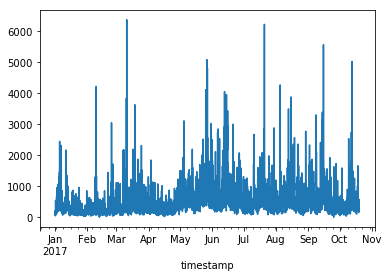

In [136]:
hr_df.volbtc.plot()

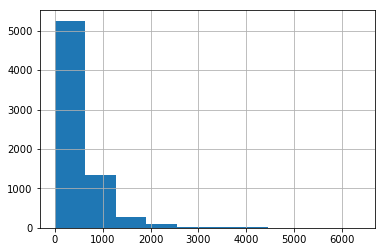

In [138]:
hr_df.volbtc.hist()

In [167]:
bins = [0, 1000, 2000, 3000, 5000]
group_names = [0, 1, 2, 3]
hr_df['volbtccat'] = pd.cut(hr_df.volbtc, bins, labels=group_names)

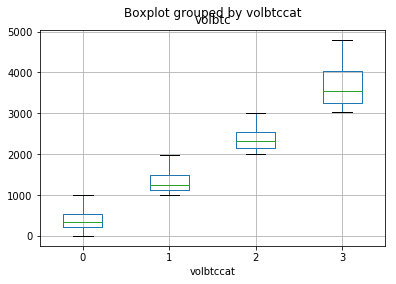

In [168]:
hr_df.boxplot(column=['volbtc'], by='volbtccat')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c4ad2e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13c6519e8>]], dtype=object)

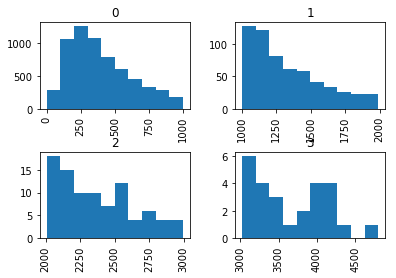

In [169]:
hr_df.hist('volbtc', by='volbtccat')

In [188]:
hr_df['returns'] = hr_df.close / hr_df.close.shift(1) - 1

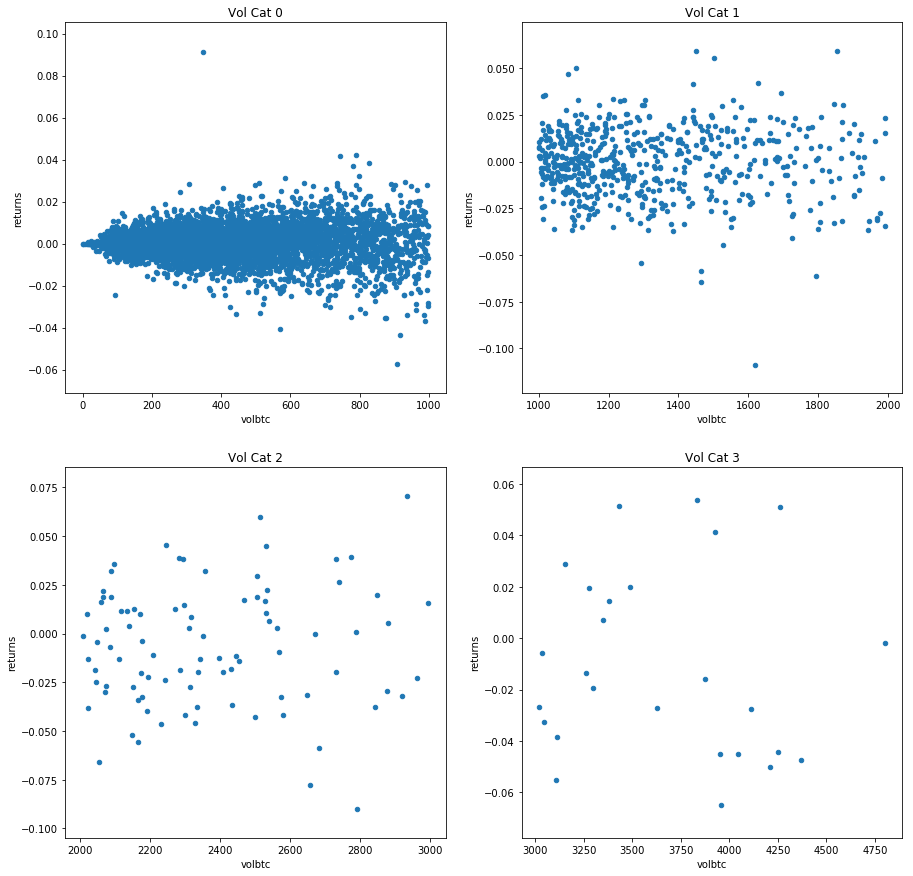

In [189]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
hr_df[hr_df.volbtccat==0].plot.scatter(x='volbtc', y='returns', ax=ax[0,0])
ax[0,0].set_title('Vol Cat 0')
hr_df[hr_df.volbtccat==1].plot.scatter(x='volbtc', y='returns', ax=ax[0,1])
ax[0,1].set_title('Vol Cat 1')
hr_df[hr_df.volbtccat==2].plot.scatter(x='volbtc', y='returns', ax=ax[1,0])
ax[1,0].set_title('Vol Cat 2')
hr_df[hr_df.volbtccat==3].plot.scatter(x='volbtc', y='returns', ax=ax[1,1])
ax[1,1].set_title('Vol Cat 3')

In [208]:
df = pd.read_csv("./coinbaseBTCUSD-withsignals-2hr.csv")
df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S')
df.index = df.timestamp
del df['timestamp']

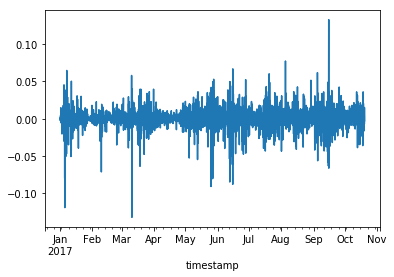

In [209]:
df.bh_returns.plot()

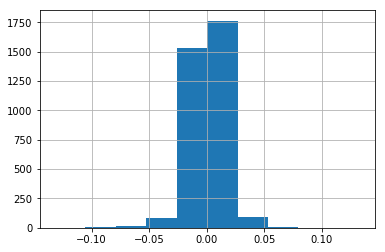

In [210]:
df.bh_returns.hist()

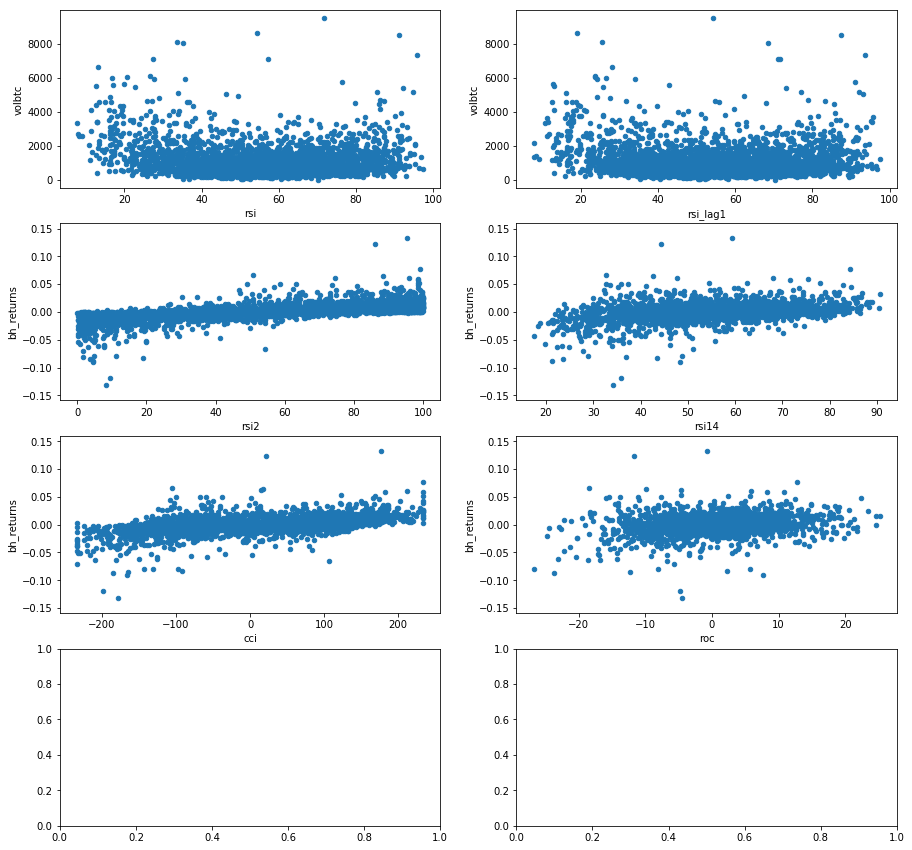

In [214]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,15))
df.plot.scatter(x='rsi', y='volbtc', ax=ax[0,0])
df.plot.scatter(x='rsi_lag1', y='volbtc', ax=ax[0,1])
df.plot.scatter(x='rsi2', y='bh_returns', ax=ax[1,0])
df.plot.scatter(x='rsi14', y='bh_returns', ax=ax[1,1])
df.plot.scatter(x='cci', y='bh_returns', ax=ax[2,0])
df.plot.scatter(x='roc', y='bh_returns', ax=ax[2,1])